In [1]:
# Importations des librairies
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from functions import plot_dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from functions import *

In [2]:
# Importations des données
Dispo_ali_2017 = pd.read_csv("DisponibiliteAlimentaire_2017.csv", sep=",")
Pop_00_18 = pd.read_csv("Population_2000_2018.csv", sep=",")

Dépenses_publiques = pd.read_csv("Dépenses_publiques.csv", sep=",")
Dépenses_publiques = Dépenses_publiques.drop(columns=["Code Domaine", "Domaine", "Code zone (FAO)", "Code Élément", "Élément", "Code Produit", "Code année", "Année", "Unité", "Symbole", "Description du Symbole","Note"])
Dépenses_publiques.Valeur = Dépenses_publiques.Valeur*1000000
Dépenses_publiques = Dépenses_publiques.rename(columns={"Valeur":"Dépenses publiques en US $"})

Emissions = pd.read_csv("Emissions.csv", sep=",")
Emissions = Emissions.drop(columns=["Code Domaine", "Domaine", "Code zone (FAO)", "Code Élément", "Code Produit", "Code année", "Année", "Symbole", "Description du Symbole"])

PIB = pd.read_csv("PIB.csv", sep=",")
PIB = PIB.drop(columns=["Code Domaine", "Domaine", "Code zone (FAO)", "Code Élément", "Élément", "Code Produit", "Produit", "Code année", "Année", "Unité", "Symbole", "Description du Symbole","Note"])
PIB = PIB.rename(columns={"Valeur":"PIB en US $"})
PIB["PIB en US $"] = PIB["PIB en US $"]*1000000

Dépenses_RD = pd.read_csv("Dépenses R&D.csv", sep=";")
Dépenses_RD = Dépenses_RD.drop(Dépenses_RD.iloc[:, 3:51], axis=1)
Dépenses_RD = Dépenses_RD.drop(columns=["Country Code","2018","2019","2020","Unnamed: 65"])

Sous_nutrition = pd.read_csv("FAOSTAT_data_12-17-2021.csv", sep=",")
Sous_nutrition = Sous_nutrition.drop(Sous_nutrition.iloc[:,0:3], axis=1)
Sous_nutrition = Sous_nutrition.drop(Sous_nutrition.iloc[:,1:6], axis=1)
Sous_nutrition = Sous_nutrition.drop(columns="Unité")
Sous_nutrition = Sous_nutrition.drop(Sous_nutrition.iloc[:,3:6], axis=1)
Sous_nutrition["Année"]=2017
Sous_nutrition = Sous_nutrition.rename(columns={"Valeur":"Nb de personnes en sous-nutrition"})
Sous_nutrition.loc[Sous_nutrition['Nb de personnes en sous-nutrition'] == '<0.1', 'Nb de personnes en sous-nutrition'] = 0
Sous_nutrition["Nb de personnes en sous-nutrition"] = pd.to_numeric(Sous_nutrition["Nb de personnes en sous-nutrition"])
Sous_nutrition["Nb de personnes en sous-nutrition"] = Sous_nutrition["Nb de personnes en sous-nutrition"]*1000000
Sous_nutrition = Sous_nutrition.fillna(0)

In [3]:
# Créé une copie des tables pour la révision des données
Pop_00_18r = Pop_00_18
Dispo_ali_2017r = Dispo_ali_2017
# Conversion  de la valeur de population en personnes et renommage de la colonne unité
Pop_00_18r["Valeur"] = Pop_00_18r["Valeur"]*1000
Pop_00_18r["Unité"] = "Personnes"
# Drop les colonnes inutiles
Dispo_ali_2017r = Dispo_ali_2017r.drop(columns=["Code Domaine", "Domaine", "Code zone", "Code Élément", "Code Produit", "Code année", "Symbole", "Description du Symbole"])
Pop_00_18r = Pop_00_18r.drop(columns=["Code Domaine", "Domaine", "Code zone", "Code Élément", "Élément", "Code Produit", "Produit", "Code année", "Note"])
# Dataset avec données de populations provenant d'agrégats
Pop_A = Pop_00_18r.loc[Pop_00_18r.Symbole == "A"]
# Dataset avec les données de populations officielles
Pop_X = Pop_00_18r.loc[Pop_00_18r.Symbole == "X"]
# Isole les données de populations sur l'année 2017
Pop_X = Pop_X.loc[Pop_X.Année == 2017]
# Drop les colonnes inutiles
Pop_X = Pop_X.drop(columns=["Année", "Unité", "Symbole", "Description du Symbole"])
Pop_X = Pop_X.rename(columns={"Valeur" : "Nombre d'habitants"})

In [4]:
Viandes_volailles = ["Viande, canard", "Viande, dinde", "Viande, oie", "Viande, volaille", "Viande, pigeons et autres volatiles nda"]
Viandes_volailles = pd.DataFrame(data = Viandes_volailles, columns = ["Produit"])

In [5]:
Dispo_ali_2017r2 = Dispo_ali_2017r.drop(columns=["Année","Unité"])

In [6]:
Disp_int = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Disponibilité intérieure"]
Disp_int = Disp_int.drop(columns="Élément")
Disp_int = Disp_int.rename(columns={"Valeur" : "Disponibilité intérieure"})

Importations = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Importations - Quantité"]
Importations = Importations.drop(columns="Élément")
Importations = Importations.rename(columns={"Valeur" : "Importations - Quantité"})

disp_aliq = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Disponibilité alimentaire en quantité (kg/personne/an)"]
disp_aliq = disp_aliq.drop(columns="Élément")
disp_aliq = disp_aliq.rename(columns={"Valeur" : "Disponibilité alimentaire en quantité (kg/personne/an)"})

disp_mg = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Disponibilité de matière grasse en quantité (g/personne/jour)"]
disp_mg = disp_mg.drop(columns="Élément")
disp_mg = disp_mg.rename(columns={"Valeur" : "Disponibilité de matière grasse en quantité (g/personne/jour)"})

disp_prot = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Disponibilité de protéines en quantité (g/personne/jour)"]
disp_prot = disp_prot.drop(columns="Élément")
disp_prot = disp_prot.rename(columns={"Valeur" : "Disponibilité de protéines en quantité (g/personne/jour)"})

Nourriture = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Nourriture"]
Nourriture = Nourriture.drop(columns="Élément")
Nourriture = Nourriture.rename(columns={"Valeur" : "Nourriture"})

Disp_ali = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Disponibilité alimentaire (Kcal/personne/jour)"]
Disp_ali = Disp_ali.drop(columns="Élément")
Disp_ali = Disp_ali.rename(columns={"Valeur" : "Disponibilité alimentaire (Kcal/personne/jour)"})

Résidus = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Résidus"]
Résidus = Résidus.drop(columns="Élément")
Résidus = Résidus.rename(columns={"Valeur" : "Résidus"})

Exportations = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Exportations - Quantité"]
Exportations = Exportations.drop(columns="Élément")
Exportations = Exportations.rename(columns={"Valeur" : "Exportations - Quantité"})

Var_st = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Variation de stock"]
Var_st = Var_st.drop(columns="Élément")
Var_st = Var_st.rename(columns={"Valeur" : "Variation de stock"})

Production = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Production"]
Production = Production.drop(columns="Élément")
Production = Production.rename(columns={"Valeur" : "Production"})

Pertes = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Pertes"]
Pertes = Pertes.drop(columns="Élément")
Pertes = Pertes.rename(columns={"Valeur" : "Pertes"})

Alim_t = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Alimentation pour touristes"]
Alim_t = Alim_t.drop(columns="Élément")
Alim_t = Alim_t.rename(columns={"Valeur" : "Alimentation pour touristes"})

Autres = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Autres utilisations (non alimentaire)"]
Autres = Autres.drop(columns="Élément")
Autres = Autres.rename(columns={"Valeur" : "Autres utilisations (non alimentaire)"})

Alim_ani = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Aliments pour animaux"]
Alim_ani = Alim_ani.drop(columns="Élément")
Alim_ani = Alim_ani.rename(columns={"Valeur" : "Aliments pour animaux"})

Traitement = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Traitement"]
Traitement = Traitement.drop(columns="Élément")
Traitement = Traitement.rename(columns={"Valeur" : "Traitement"})

Semences = Dispo_ali_2017r2.loc[Dispo_ali_2017r["Élément"]=="Semences"]
Semences = Semences.drop(columns="Élément")
Semences = Semences.rename(columns={"Valeur" : "Semences"})

In [7]:
Tab1 = pd.merge(Semences, Traitement, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Alim_ani, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Autres, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Alim_t, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Pertes, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Production, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Var_st, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Exportations, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Résidus, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Disp_ali, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Nourriture, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, disp_prot, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, disp_mg, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, disp_aliq, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Importations, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Disp_int, on=["Zone","Produit"], how="outer")
Tab1 = pd.merge(Tab1, Pop_X, on="Zone", how="left")
Tab1 = Tab1.fillna(0)

# Indicateurs

## Nombre d'habitants

In [8]:
Pop_X = Pop_X.sort_values(by="Nombre d'habitants", ascending=False)
Pop_X.head(10)

,Zone,Nombre d'habitants
823,"Chine, continentale",1.421022e+09
1952,Inde,1.338677e+09
1230,États-Unis d'Amérique,3.250848e+08
1971,Indonésie,2.646510e+08
3029,Pakistan,2.079062e+08
595,Brésil,2.078338e+08
2877,Nigéria,1.908732e+08
378,Bangladesh,1.596854e+08
1268,Fédération de Russie,1.455301e+08
2123,Japon,1.275027e+08


## Disponibilité intérieure

In [9]:
# Calcule les chiffres de disponibilité intérieure générale par pays
Disp_int_tot = Tab1.groupby(by="Zone", as_index=False).sum()
Disp_int_tot = Disp_int_tot.drop(columns="Nombre d'habitants")
Disp_int_tot

,Zone,Semences,Traitement,Aliments pour animaux,Autres utilisations (non alimentaire),Alimentation pour touristes,Pertes,Production,Variation de stock,Exportations - Quantité,Résidus,Disponibilité alimentaire (Kcal/personne/jour),Nourriture,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Disponibilité intérieure
0,Afghanistan,470.0,115.0,456.0,94.0,0.0,1146.0,11609.0,426.0,601.0,-111.0,1997.0,12968.0,54.09,30.63,357.31,4555.0,15139.0
1,Afrique du Sud,212.0,21564.0,9371.0,1448.0,0.0,3108.0,68455.0,-322.0,10968.0,-594.0,2987.0,31726.0,83.36,81.92,556.42,9020.0,66840.0
2,Albanie,53.0,113.0,697.0,177.0,0.0,321.0,4231.0,72.0,156.0,-115.0,3400.0,3631.0,119.50,117.57,1260.49,884.0,4879.0
3,Algérie,358.0,993.0,4884.0,2405.0,0.0,3683.0,26763.0,374.0,743.0,-22.0,3345.0,33056.0,92.85,79.62,798.71,19718.0,45365.0
4,Allemagne,1712.0,51109.0,30904.0,8316.0,0.0,5756.0,167828.0,651.0,58793.0,-831.0,3559.0,77988.0,104.07,147.96,943.24,66550.0,174960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,Émirats arabes unis,6.0,1068.0,1479.0,2661.0,0.0,525.0,1793.0,95.0,4914.0,94.0,3370.0,5958.0,107.26,89.31,627.67,14986.0,11795.0
170,Équateur,140.0,9955.0,1017.0,2475.0,0.0,860.0,30843.0,377.0,8897.0,-102.0,2585.0,9465.0,65.77,89.24,563.62,2134.0,23810.0
171,États-Unis d'Amérique,12380.0,152924.0,151389.0,171964.0,0.0,36551.0,974034.0,1454.0,207278.0,2576.0,3762.0,322036.0,113.61,167.00,990.38,84507.0,849821.0
172,Éthiopie,1038.0,4577.0,4710.0,4126.0,0.0,2915.0,52164.0,-1983.0,1259.0,-6.0,2304.0,38502.0,65.64,26.80,361.77,2967.0,55860.0


## Part de la viande de volaille

In [10]:
# Isole les chiffres de la quantité de volaille utilisé comme nourriture et la disponibilité de volaille par pays
Disp_int_vv = Tab1.loc[Tab1["Produit"]=="Viande de Volailles"]
Disp_int_vv = Disp_int_vv.drop(Disp_int_vv.iloc[:, 1:13], axis = 1)
Disp_int_vv = Disp_int_vv.drop(Disp_int_vv.iloc[:, 2:6], axis = 1)
Disp_int_vv = Disp_int_vv.rename(columns={"Nourriture" : "Nourriture_volaille", "Disponibilité intérieure" : "Disponibilité_volaille"})
Disp_int_vv.sort_values(by="Disponibilité_volaille", ascending=False).head(10)

,Zone,Nourriture_volaille,Disponibilité_volaille,Nombre d'habitants
3101,États-Unis d'Amérique,18100.0,18266.0,3.250848e+08
2730,"Chine, continentale",17518.0,18161.0,1.421022e+09
13307,Brésil,9982.0,9982.0,2.078338e+08
3115,Fédération de Russie,4509.0,4556.0,1.455301e+08
10917,Mexique,4058.0,4219.0,1.247773e+08
10483,Inde,2965.0,3661.0,1.338677e+09
12660,Japon,2359.0,2415.0,1.275027e+08
3408,Indonésie,1904.0,2323.0,2.646510e+08
4197,Royaume-Uni de Grande-Bretagne et d'Irlande du...,2131.0,2234.0,6.672746e+07
13530,Iran (République islamique d'),2220.0,2220.0,8.067388e+07


In [11]:
Disp_int_totvv = pd.merge(Disp_int_vv, Disp_int_tot, on="Zone", how="outer")
Disp_int_totvv = Disp_int_totvv.fillna(0)
Disp_int_totvv = Disp_int_totvv.drop(Disp_int_totvv.iloc[:, 4:15], axis=1)
Disp_int_totvv = Disp_int_totvv.drop(Disp_int_totvv.iloc[:, 5:9], axis=1)
# Calcule le pourcentage de nourriture consommée qui correspond à de la viande de volaille
# Nourriture_volaille / Nourriture
Disp_int_totvv["v/Nourriture"]= Disp_int_totvv["Nourriture_volaille"]/Disp_int_totvv["Nourriture"]*100
# Calcule le pourcentage de nourriture disponible qui correspond à de la viande de volaille
# Disponibilité_volaille / Disponibilité_intérieure
Disp_int_totvv["v/Disponibilité"]= Disp_int_totvv["Disponibilité_volaille"]/Disp_int_totvv["Disponibilité intérieure"]*100
# Calcule le pourcentage de viande de volaille disponible qui est consommée
# Nourriture_volaille / Disponibilité_volaille
Disp_int_totvv["vNourr/vDisp"]= Disp_int_totvv["Nourriture_volaille"]/Disp_int_totvv["Disponibilité_volaille"]*100
Disp_int_totvv.sort_values(by="v/Nourriture", ascending=False).head(10)

,Zone,Nourriture_volaille,Disponibilité_volaille,Nombre d'habitants,Nourriture,Disponibilité intérieure,v/Nourriture,v/Disponibilité,vNourr/vDisp
70,Saint-Kitts-et-Nevis,3.0,4.0,52045.0,23.0,50.0,13.043478,8.000000,75.000000
71,Saint-Vincent-et-les Grenadines,8.0,8.0,109827.0,67.0,206.0,11.940299,3.883495,100.000000
73,Trinité-et-Tobago,75.0,76.0,1384059.0,704.0,893.0,10.653409,8.510638,98.684211
69,Sainte-Lucie,10.0,11.0,180954.0,96.0,134.0,10.416667,8.208955,90.909091
57,Grenade,5.0,8.0,110874.0,54.0,87.0,9.259259,9.195402,62.500000
46,Antigua-et-Barbuda,5.0,7.0,95426.0,59.0,84.0,8.474576,8.333333,71.428571
112,Samoa,13.0,15.0,195352.0,159.0,346.0,8.176101,4.335260,86.666667
133,Arabie saoudite,1435.0,1435.0,33101179.0,18086.0,32403.0,7.934314,4.428602,100.000000
22,Israël,556.0,636.0,8243848.0,7267.0,11964.0,7.651025,5.315948,87.421384
48,Barbade,13.0,17.0,286232.0,171.0,407.0,7.602339,4.176904,76.470588


In [12]:
Disp_int_vv2 = Tab1.loc[Tab1["Produit"]=="Viande de Volailles"]
Disp_int_vv2 = Disp_int_vv2.drop(columns=["Semences", "Aliments pour animaux"])
# Converti les milliers de tonnes en kg
Disp_int_vv2["Nourriture"] = Disp_int_vv2["Nourriture"]*1000000
Disp_int_vv2["Production"] = Disp_int_vv2["Production"]*1000000
Disp_int_vv2["Importations - Quantité"] = Disp_int_vv2["Importations - Quantité"]*1000000
Disp_int_vv2["Exportations - Quantité"] = Disp_int_vv2["Exportations - Quantité"]*1000000
# Calcule Nourriture_volaille / Nombre d'habitants
Disp_int_vv2["Viande_volaille/Pop"] = Disp_int_vv2["Nourriture"]/Disp_int_vv2["Nombre d'habitants"]*100
# Calcule Production_volaille / Nombre d'habitants
Disp_int_vv2["Prod/Pop"] = Disp_int_vv2["Production"]/Disp_int_vv2["Nombre d'habitants"]*100
# Calcule Importation_volaille / Nombre d'habitants
Disp_int_vv2["Imp/Pop"] = Disp_int_vv2["Importations - Quantité"]/Disp_int_vv2["Nombre d'habitants"]*100
# Calcule Exportation_volaille / Nombre d'habitants
Disp_int_vv2["Exp/Pop"] = Disp_int_vv2["Exportations - Quantité"]/Disp_int_vv2["Nombre d'habitants"]*100
Disp_int_vv2.sort_values(by="Nombre d'habitants")

,Zone,Produit,Traitement,Autres utilisations (non alimentaire),Alimentation pour touristes,Pertes,Production,Variation de stock,Exportations - Quantité,Résidus,...,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Disponibilité intérieure,Nombre d'habitants,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop
8855,Saint-Kitts-et-Nevis,Viande de Volailles,0.0,0.0,1.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,19.22,11.91,55.77,4000000.0,4.0,5.204500e+04,5764.242482,0.000000,7685.656643,0.000000
7250,Dominique,Viande de Volailles,0.0,0.0,2.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,11.52,11.26,35.19,4000000.0,4.0,7.145800e+04,4198.270313,0.000000,5597.693750,0.000000
6587,Antigua-et-Barbuda,Viande de Volailles,0.0,0.0,2.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,...,17.77,17.55,54.10,7000000.0,7.0,9.542600e+04,5239.662147,0.000000,7335.527005,0.000000
8878,Saint-Vincent-et-les Grenadines,Viande de Volailles,0.0,0.0,0.0,0.0,0.000000e+00,1.0,0.000000e+00,0.0,...,25.10,15.06,72.31,9000000.0,8.0,1.098270e+05,7284.183306,0.000000,8194.706220,0.000000
7564,Grenade,Viande de Volailles,0.0,0.0,3.0,0.0,1.000000e+06,-0.0,0.000000e+00,-0.0,...,15.50,13.99,45.70,7000000.0,8.0,1.108740e+05,4509.623537,901.924707,6313.472951,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,Pakistan,Viande de Volailles,0.0,0.0,0.0,64.0,1.281000e+09,-3.0,4.000000e+06,-0.0,...,1.97,1.25,5.86,2000000.0,1282.0,2.079062e+08,585.841090,616.143215,0.961972,1.923944
3408,Indonésie,Viande de Volailles,306.0,0.0,0.0,113.0,2.301000e+09,-21.0,0.000000e+00,0.0,...,2.42,1.61,7.19,1000000.0,2323.0,2.646510e+08,719.438153,869.447054,0.377856,0.000000
3101,États-Unis d'Amérique,Viande de Volailles,77.0,89.0,0.0,0.0,2.191400e+10,80.0,3.692000e+09,-0.0,...,19.93,14.83,55.68,123000000.0,18266.0,3.250848e+08,5567.778761,6741.011258,37.836287,1135.703822
10483,Inde,Viande de Volailles,0.0,0.0,0.0,695.0,3.545000e+09,-119.0,4.000000e+06,0.0,...,0.75,0.47,2.22,0.0,3661.0,1.338677e+09,221.487370,264.813735,0.000000,0.298803


In [13]:
# Affiche les données de production, d'importation, de consommation et d'exportation pour la viande de volaille par pays.
Disp_int_vv3 = Disp_int_vv2.drop(columns=["Traitement", "Autres utilisations (non alimentaire)", "Alimentation pour touristes", "Produit", "Pertes", "Variation de stock","Résidus", "Disponibilité alimentaire (Kcal/personne/jour)","Disponibilité de protéines en quantité (g/personne/jour)","Disponibilité de matière grasse en quantité (g/personne/jour)","Disponibilité alimentaire en quantité (kg/personne/an)", "Disponibilité intérieure", "Nombre d'habitants", "Production", "Importations - Quantité", "Exportations - Quantité","Nourriture"])
Disp_int_vv3

,Zone,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop
1911,Tchad,46.614604,39.955375,6.659229,0.000000
2188,Allemagne,1946.565412,1831.634577,1018.650141,781.529681
2197,Angola,1056.452601,140.860347,929.007525,0.000000
2315,Autriche,1814.079319,1678.023370,1247.179532,884.363668
2404,Bélarus,2793.582506,4899.351138,222.216790,1608.426291
...,...,...,...,...,...
13998,Tunisie,1705.523000,1862.955892,0.000000,34.985087
14012,Turquie,2063.699780,2702.287884,3.698387,528.869298
14332,Djibouti,317.763285,0.000000,317.763285,0.000000
15948,Ouzbékistan,0.000000,0.000000,0.000000,0.000000


Indicateurs : Productions, Importation, Exportation et Consommation

On cherche à cibler des pays qui produisent et exportent peu de viande de volaille et qui au contraire importent et consomme beaucoup. Plus un pays produit et exporte moins il sera intéressé par nos produits.

# Protéines animales

In [14]:
#Calcule les données de protéines animales
Prot_anim = Tab1.loc[Tab1["Produit"].isin(["Viande de Bovins","Viande d'Ovins/Caprins","Viande de Suides","Viande, Autre","Viande de Volailles"])]
Prot_anim = Prot_anim.groupby(by="Zone", as_index=False).sum()
Prot_anim = Prot_anim.drop(columns=["Semences","Aliments pour animaux","Nourriture","Traitement", "Autres utilisations (non alimentaire)", "Alimentation pour touristes", "Pertes", "Variation de stock","Résidus","Disponibilité de protéines en quantité (g/personne/jour)","Disponibilité de matière grasse en quantité (g/personne/jour)","Disponibilité alimentaire en quantité (kg/personne/an)", "Disponibilité intérieure", "Nombre d'habitants", "Production", "Importations - Quantité", "Exportations - Quantité"])
Prot_anim = Prot_anim.rename(columns={"Disponibilité alimentaire (Kcal/personne/jour)":"Disponibilité protéines animales (Kcal/personne/jour)"})
Prot_anim

,Zone,Disponibilité protéines animales (Kcal/personne/jour)
0,Afghanistan,47.0
1,Afrique du Sud,308.0
2,Albanie,263.0
3,Algérie,83.0
4,Allemagne,360.0
...,...,...
167,Émirats arabes unis,247.0
168,Équateur,203.0
169,États-Unis d'Amérique,459.0
170,Éthiopie,30.0


# Sous-nutrition

In [15]:
# Cacule les besoins moyens en calorie d'une personne
besoins = (2400+2700+2000+2200)/4
# Jointure entre les tables contenant les données de population et les données de disponibilité intérieure géénrales par pays
ss_nut = pd.merge(Disp_int_tot, Pop_X, on="Zone", how="left")
# Calcule la différence entre le nombre de personnes théorique que le pays peut nourrir et le nombre d'habitants
# (Dispo_alimentaire * Nb_habitants / besoins) - Nb_habitants
ss_nut["Diff_pop_nourrissable"]=(ss_nut["Disponibilité alimentaire (Kcal/personne/jour)"]*ss_nut["Nombre d'habitants"]/besoins)-ss_nut["Nombre d'habitants"]
ss_nut.sort_values(by="Diff_pop_nourrissable", ascending=True).head(10)

,Zone,Semences,Traitement,Aliments pour animaux,Autres utilisations (non alimentaire),Alimentation pour touristes,Pertes,Production,Variation de stock,Exportations - Quantité,Résidus,Disponibilité alimentaire (Kcal/personne/jour),Nourriture,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Disponibilité intérieure,Nombre d'habitants,Diff_pop_nourrissable
0,Afghanistan,470.0,115.0,456.0,94.0,0.0,1146.0,11609.0,426.0,601.0,-111.0,1997.0,12968.0,54.09,30.63,357.31,4555.0,15139.0,36296113.0,-5.120484e+06
91,Madagascar,330.0,952.0,618.0,1971.0,0.0,1038.0,14082.0,-286.0,273.0,-36.0,1901.0,10792.0,42.94,23.46,422.08,1568.0,15667.0,25570512.0,-4.663182e+06
80,Kenya,193.0,4463.0,1963.0,441.0,0.0,1772.0,26467.0,1000.0,1369.0,-533.0,2125.0,23090.0,60.87,45.09,459.71,7290.0,31394.0,50221142.0,-4.320098e+06
114,Ouganda,170.0,5592.0,438.0,314.0,0.0,915.0,29825.0,116.0,1973.0,-148.0,2143.0,22210.0,52.32,44.67,539.65,1766.0,29493.0,41166588.0,-3.222503e+06
133,République populaire démocratique de Corée,170.0,676.0,1174.0,804.0,0.0,1090.0,14515.0,-1053.0,128.0,-8.0,2033.0,12532.0,52.27,38.13,492.71,1001.0,16438.0,25429825.0,-3.193767e+06
165,Yémen,55.0,31.0,303.0,156.0,0.0,156.0,3413.0,341.0,277.0,-196.0,2062.0,8415.0,53.24,38.98,302.47,6131.0,8926.0,27834819.0,-3.148627e+06
166,Zambie,91.0,4175.0,1180.0,239.0,0.0,581.0,12992.0,469.0,831.0,-50.0,2008.0,5998.0,59.06,44.67,355.99,527.0,12219.0,16853599.0,-2.297889e+06
151,Tchad,149.0,832.0,265.0,1.0,0.0,703.0,7547.0,443.0,215.0,0.0,2092.0,5154.0,70.51,57.09,343.51,219.0,7109.0,15016753.0,-1.504905e+06
128,République centrafricaine,63.0,262.0,30.0,23.0,0.0,159.0,2670.0,6.0,2.0,-31.0,1754.0,2206.0,46.40,48.91,480.62,46.0,2706.0,4596023.0,-1.128744e+06
163,Venezuela (République bolivarienne du),58.0,3211.0,1472.0,110.0,0.0,1103.0,15593.0,-1175.0,71.0,-297.0,2247.0,15699.0,56.30,64.85,534.05,4662.0,21360.0,29402484.0,-9.864059e+05


In [16]:
# Fusionne les tables contenant les données de sous-nutrition et de population
Pop_Sous_nutrition = pd.merge(Sous_nutrition, Pop_X, on="Zone", how="outer")
# Calcule le pourcentage de la population en état de sous-nutrition pop_sous-nutrition / population * 100
Pop_Sous_nutrition["% en sous nutrition"] = Pop_Sous_nutrition["Nb de personnes en sous-nutrition"]/Pop_Sous_nutrition["Nombre d'habitants"]*100
Pop_Sous_nutrition2 = Pop_Sous_nutrition.drop(columns=["Année", "Nb de personnes en sous-nutrition", "Nombre d'habitants"])
Pop_Sous_nutrition2 = Pop_Sous_nutrition2.fillna(0)
Pop_Sous_nutrition2.sort_values(by="% en sous nutrition", ascending=True)

,Zone,% en sous nutrition
235,Saint-Siège,0.000000
209,Mayotte,0.000000
112,Maldives,0.000000
114,Malte,0.000000
116,Maurice,0.000000
...,...,...
158,République populaire démocratique de Corée,42.863055
152,République centrafricaine,45.691677
201,Yémen,46.704094
79,Haïti,48.259182


Indicateur : Taux de population en sous-nutrition

On cherche à cibler des pays où le taux de population en sous-nutrition est nul, un haut taux de sous-nutrition signifie que le pays est pauvre et est incapable de nourrir sa population.

## Croissance démographique

In [17]:
# Créé 2 tables, une pour la population de 2007 et une pour la population de 2017
Croissance = Pop_00_18r
Croissance = Croissance.loc[Croissance["Symbole"]=="X"]
Croissance = Croissance.drop(columns=["Unité", "Description du Symbole", "Symbole"])
Croissance_2007 = Croissance.loc[Croissance["Année"]==2007]
Croissance_2017 = Croissance.loc[Croissance["Année"]==2017]
Croissance_2007 = Croissance_2007.rename(columns={"Valeur":"Population_2007"})
Croissance_2017 = Croissance_2017.rename(columns={"Valeur":"Population_2017"})
# Fusionne les 2 tables pour effectuer le calcul (pop2017 - pop2007) / pop2007 * 100 qui calcule le taux de croissance
Croissance_2007_2017 = pd.merge(Croissance_2007, Croissance_2017, on="Zone", how="inner")
Croissance_2007_2017["Taux de croissance démographique"]=(Croissance_2007_2017["Population_2017"]-Croissance_2007_2017["Population_2007"])/Croissance_2007_2017["Population_2007"]*100
Croissance_2007_2017 = Croissance_2007_2017.drop(columns=["Année_x", "Population_2007", "Année_y", "Population_2017"])
Croissance_2007_2017.sort_values(by="Taux de croissance démographique", ascending=False)

,Zone,Taux de croissance démographique
170,Qatar,123.625408
154,Oman,75.598440
115,Koweït,61.983555
110,Jordanie,56.441326
56,Émirats arabes unis,53.792384
...,...,...
117,Lettonie,-11.236670
168,Porto Rico,-12.517435
122,Lituanie,-12.690044
171,République arabe syrienne,-13.998091


Indicateur : Taux d'évolution de la population

On cherche à cibler des pays dont le taux de croissance est fort, plus le taux de croissance est fort, plus le pays est prospère et plus il est susceptible de compter de nouveaux clients.

## Emissions

In [18]:
Intensité_émissions = Emissions.loc[Emissions["Élément"]=="Intensité des émissions"]
Intensité_émissions_volaille = Intensité_émissions.loc[Intensité_émissions.Produit == "Viande, volaille"]
Intensité_émissions_volaille = Intensité_émissions_volaille.drop(columns=["Élément", "Produit","Unité"])
Intensité_émissions_volaille = Intensité_émissions_volaille.rename(columns={"Valeur":"kg CO2eq/kg product"})
Intensité_émissions_volaille.sort_values(by="kg CO2eq/kg product", ascending=False)

,Zone,kg CO2eq/kg product
4833,Saint-Pierre-et-Miquelon,57.8028
1794,Éthiopie,16.0311
198,Antigua-et-Barbuda,15.3354
2196,Guinée,8.5864
4548,République démocratique du Congo,7.1605
...,...,...
3036,Lettonie,0.0000
483,Bangladesh,0.0000
2691,Islande,0.0000
2301,Guyane française,0.0000


In [19]:
Emissions2 = Emissions.loc[Emissions["Élément"]=="Émissions (CO2eq)"]
Emissions2 = Emissions2.rename(columns={"Valeur":"Émissions (CO2eq) en gigagrammes"})
Emissions2 = Emissions2.drop(columns=["Élément", "Unité"])
Emissions_vv = Emissions2.loc[Emissions2.Produit=="Viande, volaille"]
Emissions_vv = Emissions_vv.drop(columns=["Produit"])
Emissions_vv.sort_values(by="Émissions (CO2eq) en gigagrammes", ascending=False)

,Zone,Émissions (CO2eq) en gigagrammes
2578,Indonésie,8361.4107
1093,Chine,7205.3307
1165,"Chine, continentale",6968.5711
1759,États-Unis d'Amérique,5921.9937
778,Brésil,4540.4724
...,...,...
2692,Islande,0.0000
4630,République populaire démocratique de Corée,0.0000
484,Bangladesh,0.0000
2302,Guyane française,0.0000


Indicateur : Intensité des émissions pour la production de viande de volaille

On cherche a cibler des pays où l'intensité des émissions de C02 est faible, une faible intensité des émissions de CO2 implique la présence d'infrastructure pour lutter contre la pollution. Creuser

## PIB

In [20]:
PIB["PIB en US $"] = PIB["PIB en US $"]/1000
PIB.sort_values(by="PIB en US $", ascending=False)

,Zone,PIB en US $
63,États-Unis d'Amérique,1.954298e+10
39,Chine,1.270248e+10
42,"Chine, continentale",1.231049e+10
99,Japon,4.866864e+09
4,Allemagne,3.682602e+09
...,...,...
86,Îles Marshall,2.077498e+05
104,Kiribati,1.872821e+05
133,Nauru,1.287434e+05
129,Montserrat,5.966667e+04


Indicateur : PIB

On cherche a cibler des pays avec un fort PIB, un fort PIB implique que le pays sera en mesure d'acheter plus de produits.

# Tableau final

In [21]:
Tab2 = pd.merge(Disp_int_vv3, Pop_Sous_nutrition2, on="Zone", how="inner")
Tab2 = pd.merge(Tab2, Croissance_2007_2017, on="Zone", how="inner")
Tab2 = pd.merge(Tab2, Intensité_émissions_volaille, on="Zone", how="inner")
Tab2 = pd.merge(Tab2, PIB, on="Zone", how="inner")
Tab2 = pd.merge(Tab2, Prot_anim, on="Zone", how="inner")
Tab2 = Tab2.set_index("Zone")
Tab2 = Tab2.drop("Chine, continentale")
#Tab2 = Tab2.drop("Chine - RAS de Hong-Kong")
Tab2 = Tab2.drop("États-Unis d'Amérique")
Tab2

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour)
Zone,,,,,,,,,
Tchad,46.614604,39.955375,6.659229,0.000000,29.300608,38.812347,3.4988,1.039402e+07,127.0
Allemagne,1946.565412,1831.634577,1018.650141,781.529681,0.000000,1.698592,0.4539,3.682602e+09,360.0
Angola,1056.452601,140.860347,929.007525,0.000000,15.427562,42.627354,3.8153,1.221239e+08,132.0
Autriche,1814.079319,1678.023370,1247.179532,884.363668,0.000000,6.088285,0.2930,4.172379e+08,370.0
Bélarus,2793.582506,4899.351138,222.216790,1608.426291,0.000000,-0.319434,2.0995,5.472542e+07,377.0
...,...,...,...,...,...,...,...,...,...
Togo,701.437714,519.583491,207.833397,0.000000,20.783340,30.033905,3.1613,6.395472e+06,53.0
Tunisie,1705.523000,1862.955892,0.000000,34.985087,0.000000,10.953392,2.1726,3.980214e+07,117.0
Turquie,2063.699780,2702.287884,3.698387,528.869298,0.000000,16.577027,0.4373,8.589886e+08,151.0


# Clustering

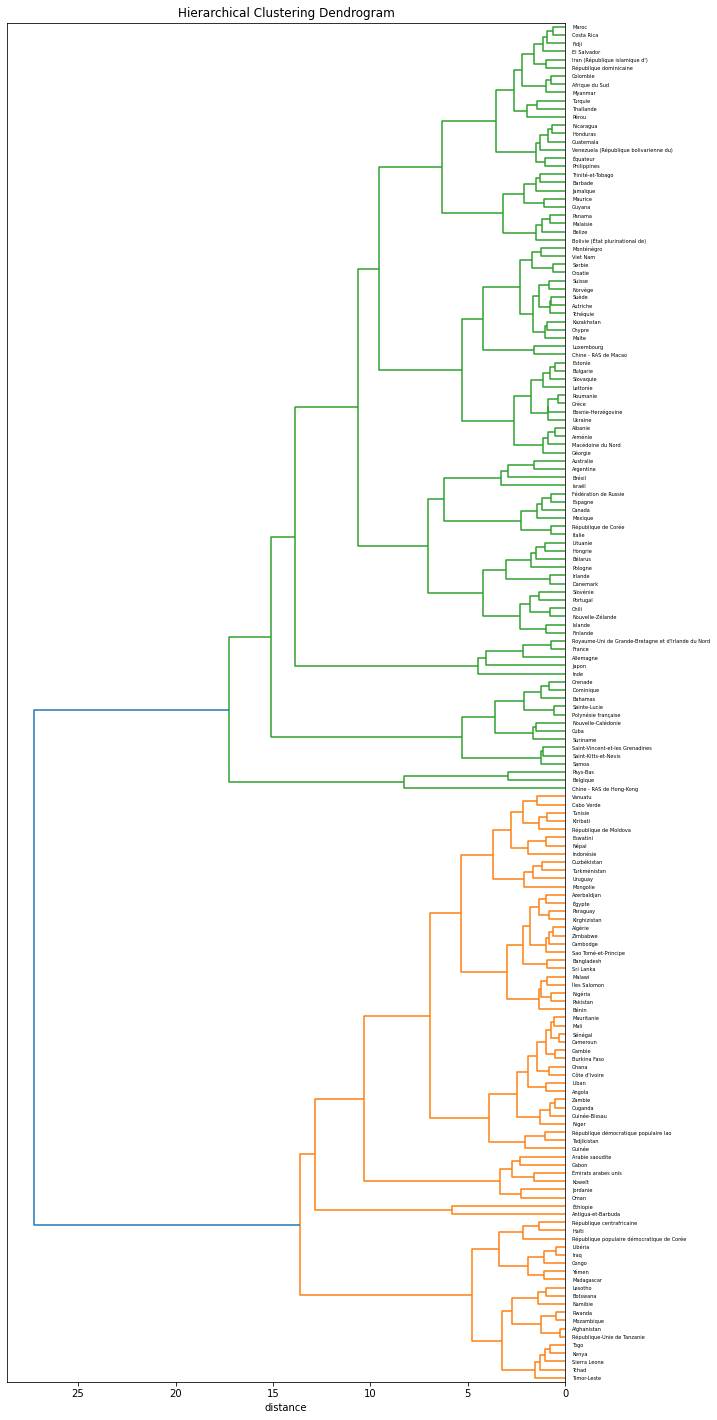

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour)
Zone,,,,,,,,,
Tchad,-1.246614,-0.914096,-0.585825,-0.309759,2.033188,1.597074,0.902126,-0.417164,-0.718165
Allemagne,-0.045307,0.144265,-0.047243,0.382295,-0.659010,-0.940145,-0.543960,5.122575,0.845778
Angola,-0.608110,-0.854491,-0.094951,-0.309759,0.758505,1.857880,1.052438,-0.248613,-0.684604
Autriche,-0.129075,0.053525,0.074380,0.473356,-0.659010,-0.640051,-0.620375,0.196583,0.912900
Bélarus,0.490248,1.956393,-0.471105,1.114522,-0.659010,-1.078104,0.237569,-0.350288,0.959885


In [22]:
# préparation des données pour le clustering
X = Tab2.values
names = Tab2.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


volaille = pd.DataFrame(X_scaled,
                  index=Tab2.index,
                  columns=Tab2.columns)
# Clustering hiérarchique
Z = linkage(volaille, method='ward', metric='euclidean')

# Affichage du dendrogramme
plot_dendrogram(Z, names)
#afficher sur 5



volaille.head(5)

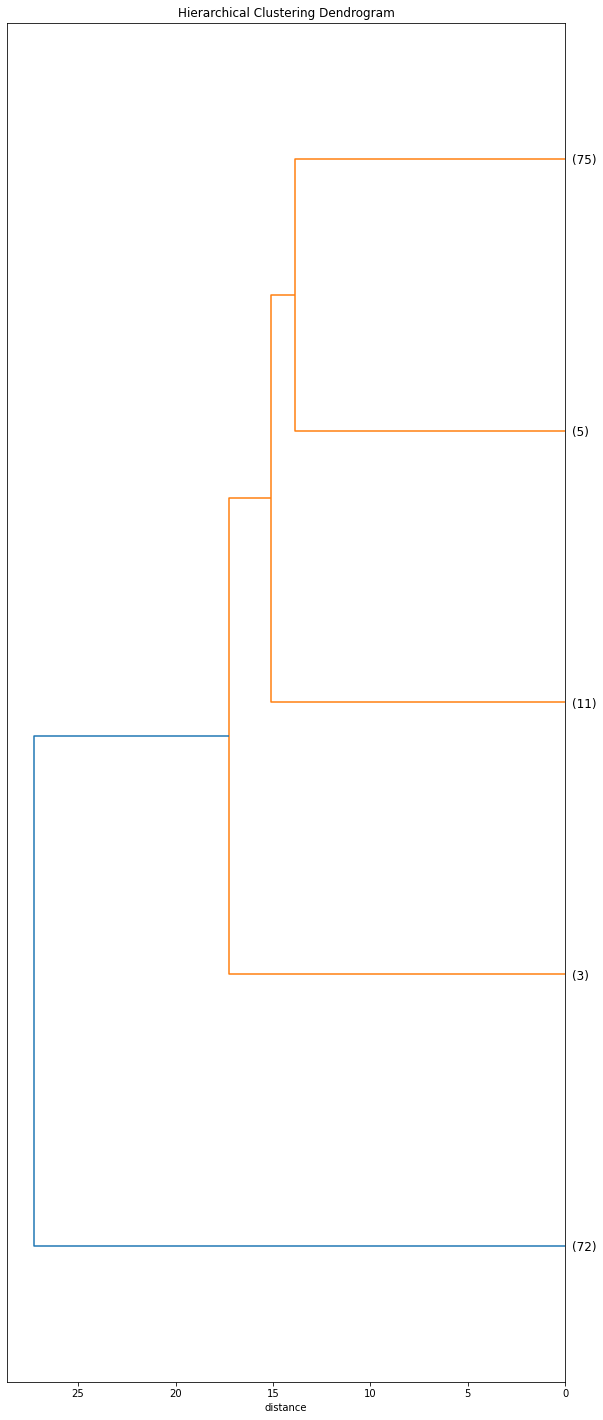

In [23]:
#Affiche le dendogram sur 5 lignes
plt.figure(figsize=(10,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(
    Z,
    p=5,
    truncate_mode="lastp",
    labels = names,
    orientation = "left",
)
plt.show()

In [24]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')
classes = pd.DataFrame({"cluster": clusters, "Zone": names})
print(classes)

     cluster                                   Zone
0          1                                  Tchad
1          4                              Allemagne
2          1                                 Angola
3          5                               Autriche
4          5                                Bélarus
..       ...                                    ...
161        1                                   Togo
162        1                                Tunisie
163        5                                Turquie
164        1                            Ouzbékistan
165        1  République démocratique populaire lao

[166 rows x 2 columns]


In [25]:
classes2 = classes.set_index("Zone")
Tab2c = pd.merge(volaille, classes2, on=["Zone"], how="outer")
résulats_clustering = Tab2c.groupby("cluster").mean()
résulats_clustering

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour)
cluster,,,,,,,,,
1,-0.694925,-0.694524,-0.241513,-0.281204,0.544947,0.757053,0.549970,-0.324499,-0.738022
2,0.545994,1.197781,2.771596,6.523289,-0.659010,-0.676024,-0.667424,0.410847,1.566221
3,1.732042,-0.628497,2.453538,-0.239205,-0.659010,-0.582340,0.048175,-0.414463,0.839676
4,-0.074501,0.155236,-0.184380,0.062213,-0.405192,-0.680933,-0.580472,4.525092,0.386663
5,0.396223,0.700663,-0.226571,0.039960,-0.373121,-0.568925,-0.469641,0.054201,0.496922


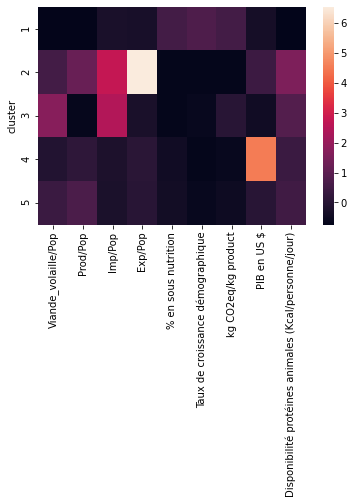

In [26]:
Heatmap = sb.heatmap(data=résulats_clustering)

Cluster 1 :

Cluster des pays les plus pauvres, consomme peu de viande de volaille, produit presque autant qu'il importe, haut taux de sous-nutrition. Très fort taux de croissance démographique.

Cluster 2 :

Largement premier en consommation de protéines animales, mais pas en consommation de viande de volaille. Exportent et importent beaucoup plus qu'ils ne produisent.

Cluster 3 :

Principalement les territoires insulaires situé autour de la mer des Caraïbes. Consomment beaucoup de viande et beaucoup de viande de volaille. Produisent et exportent peu, mais Importent beaucoup. Faible taux de sous-nutrition et taux de croissance démographique moyen. Derniers en PIB.

Cluster 4 :

Consommation de viande et de viande de volaille faible. Produisent beaucoup plus qu'ils n'importent. Faible taux de sous-nutrition et faible taux de croissance démographique.

Cluster 5 :

Consommation de viande et de viande de volaille moyenne. Produisent beaucoup et importent peu. Faible taux de sous-nutrition et taux de croissance démographique moyen.

## Cluster 1

In [27]:
Cluster1 = Tab2c.loc[Tab2c.cluster==1]
Cluster1

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Tchad,-1.246614,-0.914096,-0.585825,-0.309759,2.033188,1.597074,0.902126,-0.417164,-0.718165,1
Angola,-0.608110,-0.854491,-0.094951,-0.309759,0.758505,1.857880,1.052438,-0.248613,-0.684604,1
Indonésie,-0.821199,-0.424108,-0.589168,-0.309759,-0.075745,-0.106702,0.998915,1.099275,-1.214868,1
Madagascar,-1.095580,-0.750579,-0.589369,-0.309759,3.221732,1.102602,0.850977,-0.412967,-1.107473,1
Mozambique,-1.048767,-0.748005,-0.544785,-0.309759,2.227434,1.144052,-0.563005,-0.412903,-1.141034,1
...,...,...,...,...,...,...,...,...,...,...
Timor-Leste,-1.021803,-0.890185,-0.118493,-0.309759,1.558116,0.308279,1.300062,-0.430432,-0.416116,1
Togo,-0.832580,-0.630776,-0.478760,-0.309759,1.250605,0.996950,0.741840,-0.423196,-1.214868,1
Tunisie,-0.197714,0.162767,-0.589369,-0.278779,-0.659010,-0.307457,0.272286,-0.372801,-0.785287,1


## Cluster 2

In [28]:
Cluster2 = Tab2c.loc[Tab2c.cluster==2]
Cluster2

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Belgique,-0.478795,1.457261,0.985830,4.777007,-0.65901,-0.594757,-0.690901,0.325505,0.087299,2
Pays-Bas,0.009181,2.879743,1.311643,7.067189,-0.65901,-0.843104,-0.656042,0.825096,0.933036,2
Chine - RAS de Hong-Kong,2.107596,-0.743661,6.017316,7.725671,-0.65901,-0.590211,-0.655329,0.081939,3.678326,2


## Cluster 3

In [29]:
Cluster3 = Tab2c.loc[Tab2c.cluster==3]
Cluster3

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Bahamas,1.373920,-0.009288,2.756444,-0.309759,-0.65901,-0.157302,0.175450,-0.414001,0.677973,3
Cuba,0.223872,-0.786625,0.874982,-0.309759,-0.65901,-1.002716,0.140448,-0.286739,0.396060,3
Dominique,1.378409,-0.937698,2.389726,-0.309759,-0.65901,-0.992244,0.058429,-0.432060,0.315514,3
Grenade,1.575273,-0.404923,2.770664,-0.309759,-0.65901,-0.686862,-0.308684,-0.431146,0.288665,3
Polynésie française,1.700959,-0.723752,2.301956,-0.309759,-0.65901,-0.708076,-0.277862,-0.424159,1.624393,3
Sainte-Lucie,2.218079,-0.611257,2.351712,-0.309759,-0.65901,-0.513280,-0.201400,-0.429829,1.617681,3
Saint-Kitts-et-Nevis,2.368547,-0.937698,3.500940,-0.309759,-0.65901,-0.445722,0.008325,-0.431340,1.000158,3
Saint-Vincent-et-les Grenadines,3.329581,-0.937698,3.771857,-0.309759,-0.65901,-0.973803,0.090914,-0.431649,1.040432,3
Suriname,0.718861,0.097732,1.089803,0.466331,-0.65901,-0.263012,0.144200,-0.427993,-0.181189,3


## Cluster 4

In [30]:
Cluster4 = Tab2c.loc[Tab2c.cluster==4]
Cluster4

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Allemagne,-0.045307,0.144265,-0.047243,0.382295,-0.659010,-0.940145,-0.543960,5.122575,0.845778,4
France,0.171945,0.656535,-0.174065,0.374424,-0.659010,-0.727730,-0.582904,3.482092,1.369329,4
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,0.743165,0.668157,0.031941,0.166655,-0.659010,-0.469771,-0.628639,3.583667,1.443164,4
Inde,-1.136045,-0.781270,-0.589369,-0.309494,0.610078,-0.158010,-0.545955,3.528022,-1.476644,4
Japon,-0.106264,0.088492,-0.143165,-0.302814,-0.659010,-1.109009,-0.600903,6.909103,-0.248311,4


## Cluster 5

In [31]:
Cluster5 = Tab2c.loc[Tab2c.cluster==5]
Cluster5

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Autriche,-0.129075,0.053525,0.074380,0.473356,-0.659010,-0.640051,-0.620375,0.196583,0.912900,5
Bélarus,0.490248,1.956393,-0.471105,1.114522,-0.659010,-1.078104,0.237569,-0.350288,0.959885,5
Bosnie-Herzégovine,-0.219617,0.137432,-0.430575,-0.098389,-0.659010,-1.803457,-0.385717,-0.405569,-0.248311,5
Bulgarie,0.121579,-0.047781,0.219897,0.251288,-0.400277,-1.484156,-0.626549,-0.343913,0.060450,5
Chypre,0.331851,0.314146,0.042228,-0.234695,-0.659010,-0.310976,-0.566187,-0.398693,0.537016,5
...,...,...,...,...,...,...,...,...,...,...
Nicaragua,0.090509,0.385300,-0.539357,-0.309759,0.923960,-0.084281,-0.504447,-0.412048,-0.698028,5
République de Corée,-0.219321,0.031086,-0.446675,-0.299361,-0.659010,-0.768842,-0.520024,2.016905,0.530304,5
Serbie,-0.631604,-0.369042,-0.517040,-0.239557,-0.242766,-1.260246,-0.599099,-0.366198,0.798792,5


# ACP

In [32]:
# Calcul des composantes principales
n_comp = 6
pca = decomposition.PCA(n_components=n_comp)
pca.fit(volaille)

PCA(n_components=6)

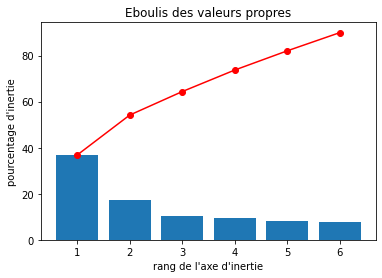

In [33]:
# Eboulis des valeurs propres
display_scree_plot(pca)

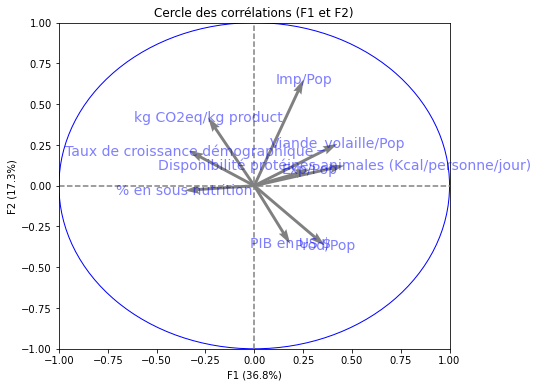

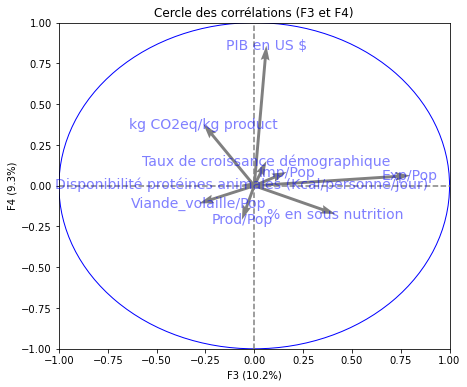

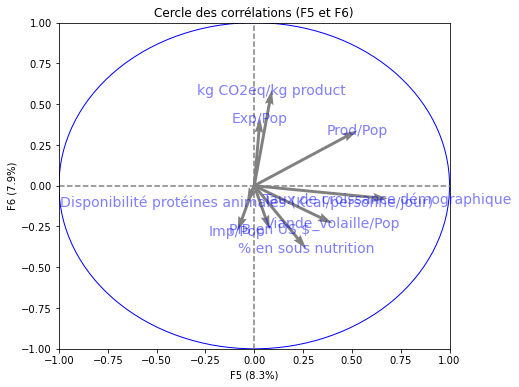

In [34]:
# Cercle des corrélations
features = volaille.columns
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

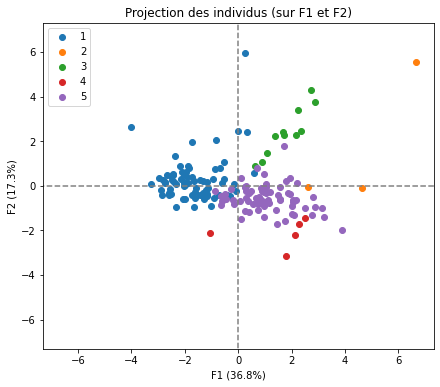

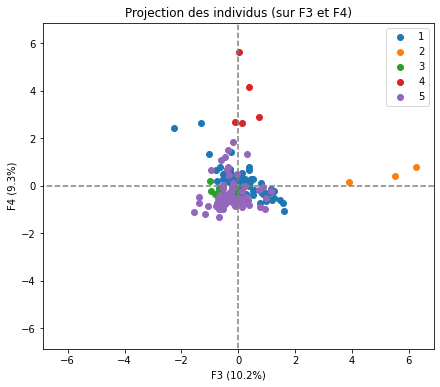

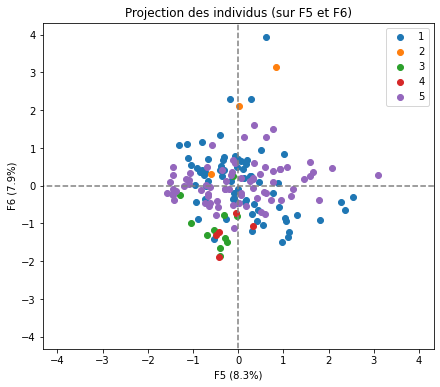

In [35]:
# Projection des individus selon la classification hiérarchique
X_projected = pca.transform(volaille)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels=None, alpha=1, illustrative_var=clusters)

plt.show()

# KMeans

In [36]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(volaille)
    distortions.append(kmeanModel.inertia_)

C:\Users\ThyEx\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


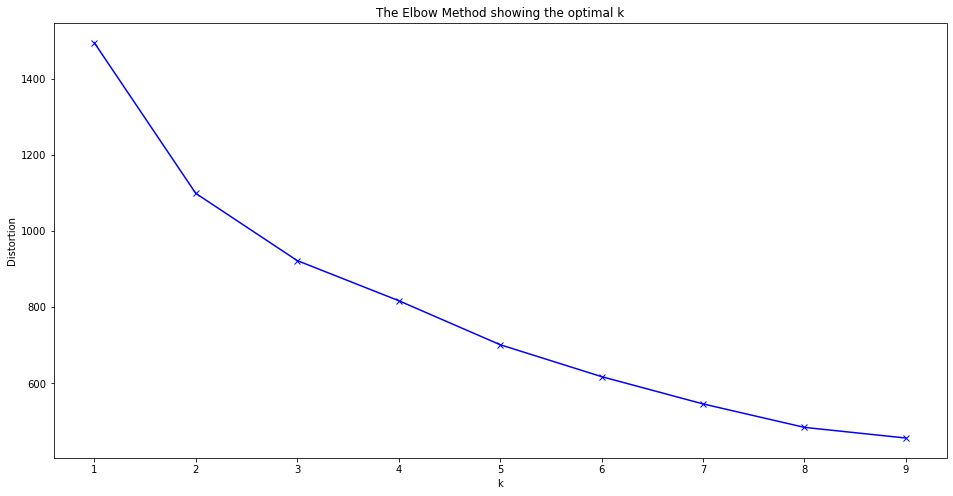

In [37]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
# Effectue le clustering Kmeans
kmeans = KMeans(n_clusters=5).fit(volaille)

# Centroids du Kmeans
centroids_k = kmeans.cluster_centers_

# Labels du Kmeans
kmeans_labels = kmeans.labels_

# Change kmeans_labels pour des valeurs de 1 à 5 au lieu de 0 à 4 
kmeans_labels = np.where(kmeans_labels==4, 5, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==3, 4, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==2, 3, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==1, 2, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==0, 1, kmeans_labels)

# Créé une nouvelle table avec les clusters du Kmeans
Tab3c = volaille

Tab3c["cluster"] = kmeans_labels

In [39]:
volaille = volaille.drop(columns="cluster")

In [40]:
résulats_clustering_k = Tab3c.groupby("cluster").mean()
résulats_clustering_k

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour)
cluster,,,,,,,,,
1,-0.789953,-0.670747,-0.360127,-0.295417,0.688805,0.726205,0.408856,-0.333729,-0.800917
2,1.855961,-0.659716,2.520252,-0.235551,-0.636660,0.082862,0.565177,-0.364092,0.990865
3,0.355723,0.623346,-0.171546,0.043167,-0.460642,-0.625184,-0.394761,-0.150597,0.434754
4,0.445172,0.795645,-0.350340,0.103014,-0.553253,-0.614251,-0.593431,3.091858,0.743417
5,0.545994,1.197781,2.771596,6.523289,-0.659010,-0.676024,-0.667424,0.410847,1.566221


<AxesSubplot:ylabel='cluster'>

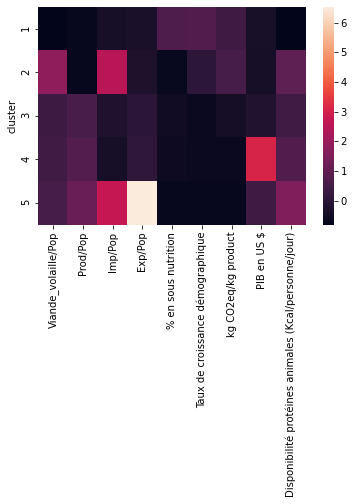

In [41]:
sb.heatmap(data=résulats_clustering_k)

## Cluster 1

In [42]:
Cluster1k = Tab3c.loc[Tab3c.cluster==1]
Cluster1k

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Tchad,-1.246614,-0.914096,-0.585825,-0.309759,2.033188,1.597074,0.902126,-0.417164,-0.718165,1
Angola,-0.608110,-0.854491,-0.094951,-0.309759,0.758505,1.857880,1.052438,-0.248613,-0.684604,1
Guatemala,0.024740,-0.117025,-0.183493,-0.273113,0.861948,0.547809,-0.623747,-0.324814,-0.698028,1
Indonésie,-0.821199,-0.424108,-0.589168,-0.309759,-0.075745,-0.106702,0.998915,1.099275,-1.214868,1
Madagascar,-1.095580,-0.750579,-0.589369,-0.309759,3.221732,1.102602,0.850977,-0.412967,-1.107473,1
...,...,...,...,...,...,...,...,...,...,...
Paraguay,-0.898581,-0.550605,-0.581619,-0.258178,0.009995,-0.066296,-0.301038,-0.373997,0.114148,1
Timor-Leste,-1.021803,-0.890185,-0.118493,-0.309759,1.558116,0.308279,1.300062,-0.430432,-0.416116,1
Togo,-0.832580,-0.630776,-0.478760,-0.309759,1.250605,0.996950,0.741840,-0.423196,-1.214868,1


## Cluster 2

In [43]:
Cluster2k = Tab3c.loc[Tab3c.cluster==2]
Cluster2k

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Antigua-et-Barbuda,2.036864,-0.937698,3.314601,-0.309759,-0.659010,-0.128766,6.523573,-0.430630,0.724958,2
Bahamas,1.373920,-0.009288,2.756444,-0.309759,-0.659010,-0.157302,0.175450,-0.414001,0.677973,2
Chine - RAS de Macao,0.856626,-0.653058,1.376725,-0.309759,-0.659010,0.543684,-0.377785,-0.356284,2.691633,2
Dominique,1.378409,-0.937698,2.389726,-0.309759,-0.659010,-0.992244,0.058429,-0.432060,0.315514,2
Grenade,1.575273,-0.404923,2.770664,-0.309759,-0.659010,-0.686862,-0.308684,-0.431146,0.288665,2
Koweït,1.654543,-0.122144,1.208207,-0.222432,-0.659010,3.181134,0.886881,-0.250780,0.355787,2
Polynésie française,1.700959,-0.723752,2.301956,-0.309759,-0.659010,-0.708076,-0.277862,-0.424159,1.624393,2
Sainte-Lucie,2.218079,-0.611257,2.351712,-0.309759,-0.659010,-0.513280,-0.201400,-0.429829,1.617681,2
Saint-Kitts-et-Nevis,2.368547,-0.937698,3.500940,-0.309759,-0.659010,-0.445722,0.008325,-0.431340,1.000158,2


## Cluster 3

In [44]:
Cluster3k = Tab3c.loc[Tab3c.cluster==3]
Cluster3k

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Autriche,-0.129075,0.053525,0.074380,0.473356,-0.659010,-0.640051,-0.620375,0.196583,0.912900,3
Bélarus,0.490248,1.956393,-0.471105,1.114522,-0.659010,-1.078104,0.237569,-0.350288,0.959885,3
Bosnie-Herzégovine,-0.219617,0.137432,-0.430575,-0.098389,-0.659010,-1.803457,-0.385717,-0.405569,-0.248311,3
Bulgarie,0.121579,-0.047781,0.219897,0.251288,-0.400277,-1.484156,-0.626549,-0.343913,0.060450,3
Chypre,0.331851,0.314146,0.042228,-0.234695,-0.659010,-0.310976,-0.566187,-0.398693,0.537016,3
...,...,...,...,...,...,...,...,...,...,...
Monténégro,-0.268566,-0.561189,0.089065,-0.309759,-0.659010,-0.967904,-0.627879,-0.425518,1.684803,3
Serbie,-0.631604,-0.369042,-0.517040,-0.239557,-0.242766,-1.260246,-0.599099,-0.366198,0.798792,3
Suisse,-0.281579,-0.301987,-0.268380,-0.267870,-0.659010,-0.222860,-0.591975,0.629902,1.261934,3


## Cluster 4

In [45]:
Cluster4k = Tab3c.loc[Tab3c.cluster==4]
Cluster4k

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Allemagne,-0.045307,0.144265,-0.047243,0.382295,-0.659010,-0.940145,-0.543960,5.122575,0.845778,4
Espagne,0.645943,0.980787,-0.355485,0.092683,-0.659010,-0.872925,-0.636997,1.547197,1.053856,4
Fédération de Russie,0.682934,0.866129,-0.506721,-0.239784,-0.659010,-0.948240,-0.636855,1.947026,0.617563,4
France,0.171945,0.656535,-0.174065,0.374424,-0.659010,-0.727730,-0.582904,3.482092,1.369329,4
Italie,-0.081836,0.342564,-0.504285,-0.042676,-0.659010,-0.832162,-0.619805,2.526639,0.798792,4
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,0.743165,0.668157,0.031941,0.166655,-0.659010,-0.469771,-0.628639,3.583667,1.443164,4
Inde,-1.136045,-0.781270,-0.589369,-0.309494,0.610078,-0.158010,-0.545955,3.528022,-1.476644,4
Japon,-0.106264,0.088492,-0.143165,-0.302814,-0.659010,-1.109009,-0.600903,6.909103,-0.248311,4
Australie,1.735567,2.111402,-0.554733,-0.158479,-0.659010,0.142678,-0.642506,1.704456,1.751925,4


## Cluster 5

In [46]:
Cluster5k = Tab3c.loc[Tab3c.cluster==5]
Cluster5k

,Viande_volaille/Pop,Prod/Pop,Imp/Pop,Exp/Pop,% en sous nutrition,Taux de croissance démographique,kg CO2eq/kg product,PIB en US $,Disponibilité protéines animales (Kcal/personne/jour),cluster
Zone,,,,,,,,,,
Belgique,-0.478795,1.457261,0.985830,4.777007,-0.65901,-0.594757,-0.690901,0.325505,0.087299,5
Pays-Bas,0.009181,2.879743,1.311643,7.067189,-0.65901,-0.843104,-0.656042,0.825096,0.933036,5
Chine - RAS de Hong-Kong,2.107596,-0.743661,6.017316,7.725671,-0.65901,-0.590211,-0.655329,0.081939,3.678326,5


# ACP

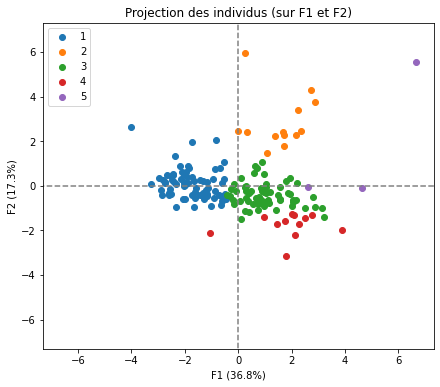

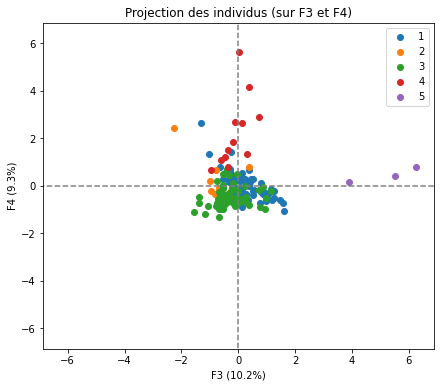

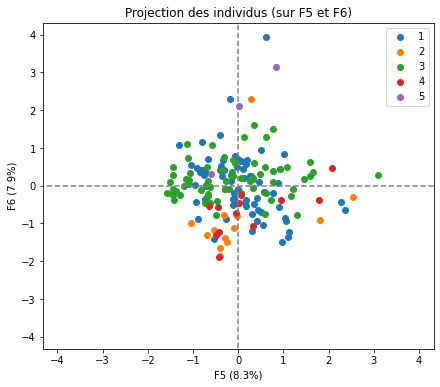

In [47]:
# Projection des individus selon le Kmeans
X_projected = pca.transform(volaille)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels=None, alpha=1, illustrative_var=kmeans_labels)
plt.show()

Choix de pays :

Cuba, Sainte Lucie, Grenade, Dominique, Bahamas ,Saint-Kitts-et-Nevis

Ces 6 pays importent beaucoup plus qu'ils ne produisent et consomment beaucoup de viande de volaille et de viande en général.

Ils sont aussi géographiquement proches, ils sont tous situés autour de la mer des Caraïbes.

In [48]:
#Use silhouette score
range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(volaille)
    centers = clusterer.cluster_centers_

    score = silhouette_score(volaille, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6, 7, 8, 9]
For n_clusters = 2, silhouette score is 0.2657144321223452)
For n_clusters = 3, silhouette score is 0.29027978467832033)
For n_clusters = 4, silhouette score is 0.2787851895517147)
For n_clusters = 5, silhouette score is 0.2140542855459892)
For n_clusters = 6, silhouette score is 0.2642148763803267)
For n_clusters = 7, silhouette score is 0.23787569311358733)
For n_clusters = 8, silhouette score is 0.24221337895704878)
For n_clusters = 9, silhouette score is 0.24712541075295952)


In [49]:
clusterer

KMeans(n_clusters=9)

In [50]:
X_projected

array([[-2.98166839e+00,  3.24634937e-01,  7.95385261e-01,
         1.24379423e-01,  7.66288846e-01, -1.84156563e-01],
       [ 2.14324319e+00, -2.19029447e+00,  3.74411783e-01,
         4.16698532e+00, -4.17435279e-01, -1.23100728e+00],
       [-2.18522633e+00,  8.86595245e-01,  1.48646063e-01,
         5.46638587e-01,  8.75979729e-01,  6.25424555e-02],
       [ 1.17232962e+00, -2.93018252e-01,  2.25101749e-01,
        -3.16943227e-03, -7.02700243e-01,  1.84029138e-02],
       [ 2.03269001e+00, -6.57803990e-01,  6.28966751e-02,
        -6.87079450e-01,  3.47958174e-01,  1.61799323e+00],
       [ 2.62886957e+00, -4.77517838e-02,  3.90129712e+00,
         1.72248288e-01,  1.41032875e-02,  2.10852696e+00],
       [ 5.61706527e-01, -8.12793554e-01, -3.92287633e-01,
        -7.01613867e-01, -1.44614753e+00,  4.83843402e-01],
       [ 9.15394187e-01, -2.22535221e-01,  8.43823831e-02,
        -6.55849901e-01, -1.19401992e+00, -8.55015495e-03],
       [ 8.47142469e-01, -1.01953651e-01, -4.987

In [52]:
volaille3 = pd.DataFrame(X_projected,
                  index=Tab2.index)
volaille3

,0,1,2,3,4,5
Zone,,,,,,
Tchad,-2.981668,0.324635,0.795385,0.124379,0.766289,-0.184157
Allemagne,2.143243,-2.190294,0.374412,4.166985,-0.417435,-1.231007
Angola,-2.185226,0.886595,0.148646,0.546639,0.875980,0.062542
Autriche,1.172330,-0.293018,0.225102,-0.003169,-0.702700,0.018403
Bélarus,2.032690,-0.657804,0.062897,-0.687079,0.347958,1.617993
...,...,...,...,...,...,...
Togo,-2.387264,0.164170,0.388247,0.005320,0.458047,0.095024
Tunisie,-0.410667,-0.419073,-0.612015,-0.234116,-0.312042,0.769108
Turquie,0.389325,-1.173786,-0.057699,0.475376,0.331137,0.193249


C:\Users\ThyEx\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


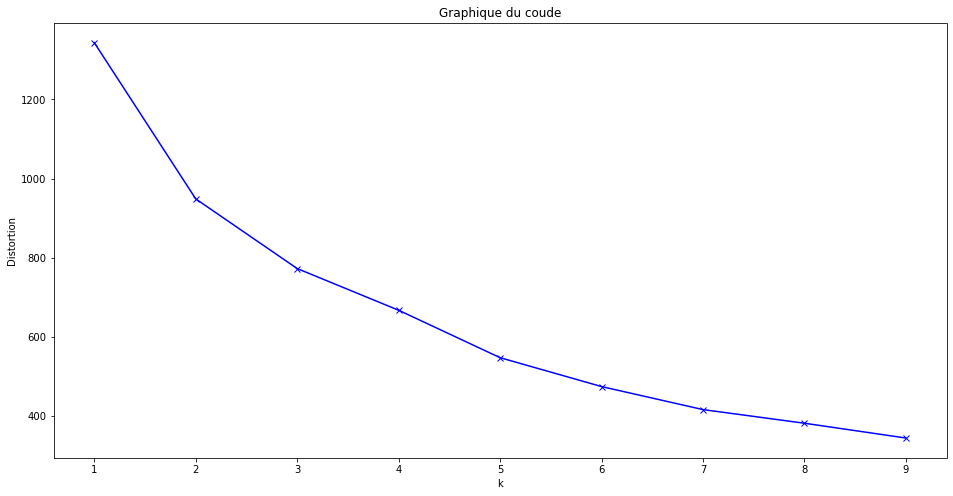

In [53]:
#Calcule le graphique du coude pour déterminer le nombre idéal de clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(volaille3)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Graphique du coude')
plt.show()

In [54]:
#Effectue le clustering Kmeans
kmeans = KMeans(n_clusters=5, n_init= 100, random_state = 9).fit(volaille3)

#Centroids du Kmeans
centroids_k = kmeans.cluster_centers_

#Labels du Kmeans
kmeans_labels = kmeans.labels_

#Change kmeans_labels pour des valeurs de 1 à 5 au lieu de 0 à 4 
kmeans_labels = np.where(kmeans_labels==4, 5, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==3, 4, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==2, 3, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==1, 2, kmeans_labels)
kmeans_labels = np.where(kmeans_labels==0, 1, kmeans_labels)

#Créé une nouvelle table avec les clusters du Kmeans
Tab4c = volaille3

Tab4c["cluster"] = kmeans_labels
#Drop la colonne cluster de la table volaille
volaille3 = volaille3.drop(columns="cluster")

#Affiche les résultats du Kmeans
résulats_clustering_k2 = Tab4c.groupby("cluster").mean()
résulats_clustering_k2

,0,1,2,3,4,5
cluster,,,,,,
1,-1.771571,0.106442,0.225516,0.030432,0.071467,0.021239
2,0.986442,-0.423572,-0.298823,-0.471146,-0.126100,0.186855
3,4.639417,1.791716,5.218553,0.453662,0.084529,1.857143
4,1.874976,-1.770674,-0.121273,2.201727,0.228898,-0.691439
5,1.577996,2.863454,-0.743581,0.163536,0.043982,-0.882078


In [56]:
# Calcul des composantes principales
n_comp = 6
pca = decomposition.PCA(n_components=n_comp)
pca.fit(volaille3)

PCA(n_components=6)

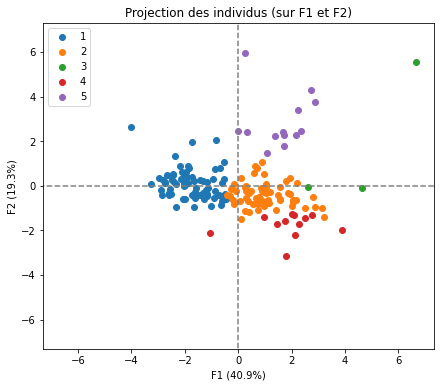

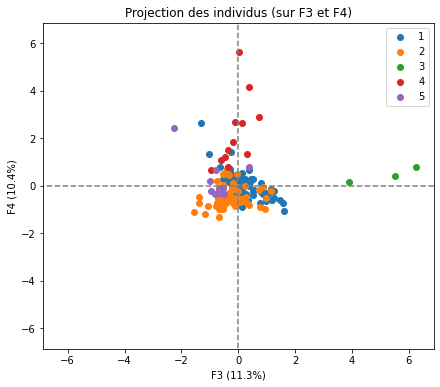

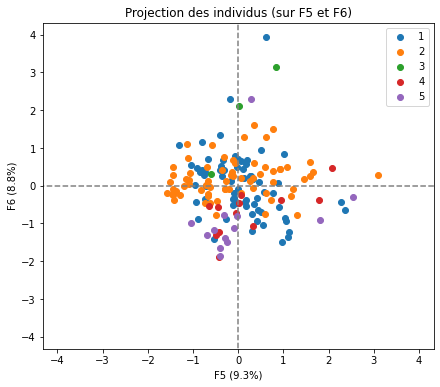

In [57]:
# Projection des individus selon le Kmeans
X_projected = pca.transform(volaille3)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels=None, alpha=1, illustrative_var=kmeans_labels)
plt.show()